# Exam Project in 22481

## Investigating phantoms

In [2]:
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.font_manager as fm
import os

# MRI

In [3]:
def load_dicom_folder(folder_path, modality=None):
    """
    Load a DICOM series from a folder into a 3D NumPy array.

    Parameters
    ----------
    folder_path : str
        Path to folder with DICOM files (all from same series).
    modality : str, optional
        "CT" or "MR" (used to decide slice order).

    Returns
    -------
    volume : np.ndarray
        3D array of stacked slices.
    header : pydicom Dataset
        Header of first slice.
    dicoms : list
        List of all DICOM datasets.
    voxel_size : tuple
        (dy, dx, dz) voxel dimensions in mm.
    """
    # Read all dicom files in folder
    dicoms = [pydicom.dcmread(os.path.join(folder_path, f))
              for f in os.listdir(folder_path)
              if not f.startswith('.')]

    # Sort by InstanceNumber
    reverse = True if modality == "CT" else False
    dicoms.sort(key=lambda d: int(d.InstanceNumber), reverse=reverse)

    # Stack into 3D volume
    if modality == "CT":
        # Convert to Hounsfield Units
        slices = []
        for d in dicoms:
            # Convert raw CT pixels to Hounsfield Units (HU)
            # HU = pixel_value * RescaleSlope + RescaleIntercept
            # Use defaults if fields are missing (slope=1, intercept=0)
            slope = getattr(d, 'RescaleSlope', 1.0)
            intercept = getattr(d, 'RescaleIntercept', 0.0)
            slices.append(d.pixel_array * slope + intercept)
        volume = np.stack(slices, axis=2)
    else:
        # MR: keep raw pixel values
        volume = np.stack([d.pixel_array for d in dicoms], axis=2)

    # Metadata
    header = dicoms[0]
    dx, dy = [float(sp) for sp in header.PixelSpacing]

    # Prefer SpacingBetweenSlices (if available) over SliceThickness
    if hasattr(header, "SpacingBetweenSlices"):
        dz = float(header.SpacingBetweenSlices)
    else:
        dz = float(header.SliceThickness)

    voxel_size = (dy, dx, dz)

    return volume, header, dicoms, voxel_size

# Paths to MR datasets (update before running!)
t1w_path = r"C:\Users\bjorn\Desktop\Spaghetti\22481exercises\A_3D_T1w\A_3D_T1w"
t2w_path = r"C:\Users\bjorn\Desktop\Spaghetti\22481exercises\A_3D_T2w\A_3D_T2w"

# Load datasets 
t1w_img3d, t1w_header, t1w_dicoms, t1w_voxel = load_dicom_folder(t1w_path, modality="MR")
t2w_img3d, t2w_header, t2w_dicoms, t2w_voxel = load_dicom_folder(t2w_path, modality="MR")

# Swap axes for these 3D datasets (collected in sagittal view)
t1w_img3d = np.transpose(t1w_img3d, (1,2,0))  
t2w_img3d = np.transpose(t2w_img3d, (1,2,0))  
t1w_voxel = (t1w_voxel[1], t1w_voxel[2], t1w_voxel[0])
t2w_voxel = (t2w_voxel[1], t2w_voxel[2], t2w_voxel[0])

print("MR T1w matrix size:", t1w_img3d.shape)
print("MR T1w voxel size (mm):", t1w_voxel)
print("MR T1w intensity range:", np.min(t1w_img3d), np.max(t1w_img3d))
print("MR T2w matrix size:", t2w_img3d.shape)
print("MR T2w voxel size (mm):", t2w_voxel)
print("MR T2w intensity range:", np.min(t2w_img3d), np.max(t2w_img3d))


MR T1w matrix size: (512, 308, 512)
MR T1w voxel size (mm): (0.4688, 0.6, 0.4688)
MR T1w intensity range: 0 1394
MR T2w matrix size: (512, 308, 512)
MR T2w voxel size (mm): (0.4688, 0.6, 0.4688)
MR T2w intensity range: 0 1772


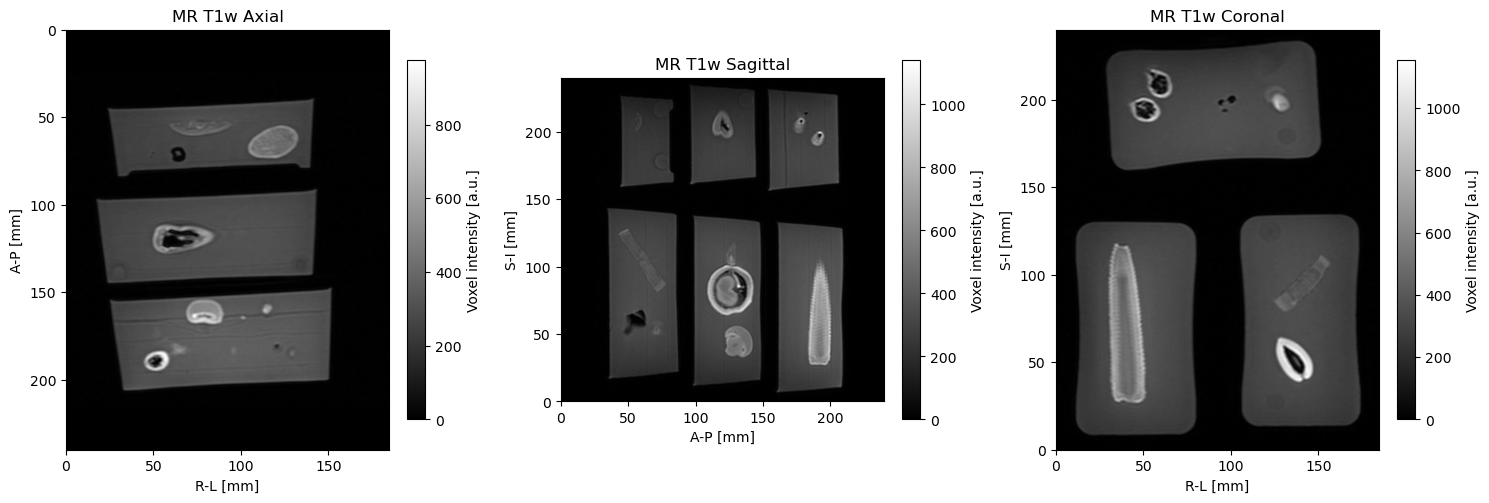

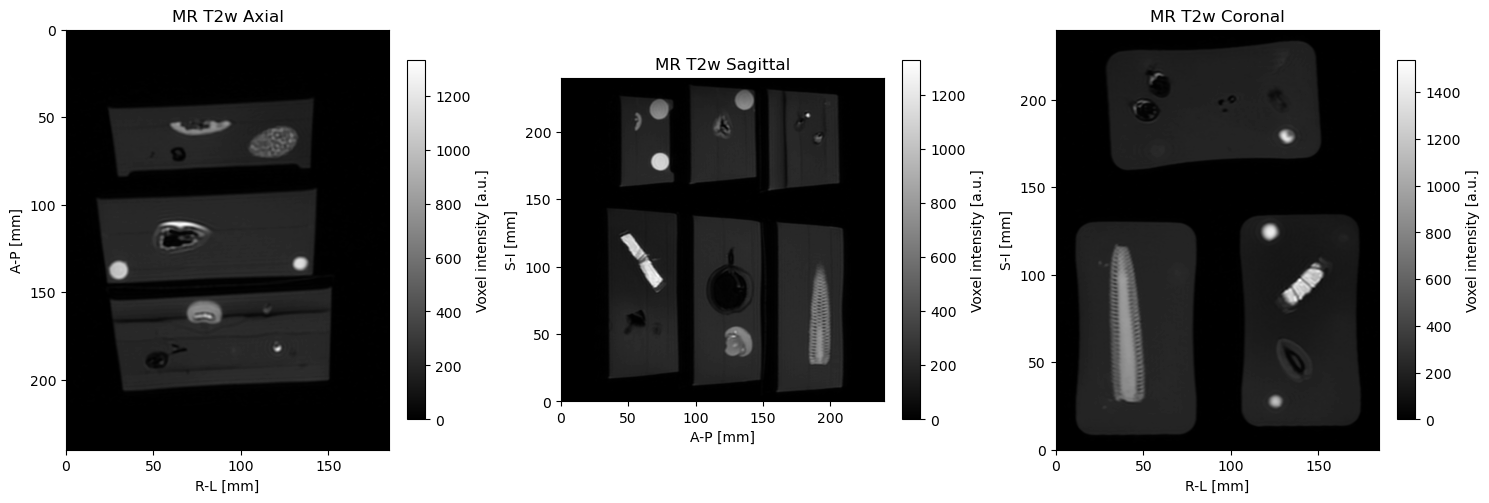

In [4]:
# Display the raw images

def show_slices(img3d, voxel_size, loc, colormap, title_prefix="", voxel_units=""):
    """Display axial, sagittal, coronal slices with correct aspect."""
    ny, nx, nz = img3d.shape

    # NB! loc is given in matrix size / grid units, whereas images are shown with axes in units of mm
    loc_AP = loc[0]
    loc_RL = loc[1]
    loc_SI = loc[2]

    # Physical lengths
    y_mm = ny * voxel_size[0]  # A-P
    x_mm = nx * voxel_size[1]  # R-L
    z_mm = nz * voxel_size[2]  # S-I

    fig, axes = plt.subplots(1, 3, figsize=(15, 10))

    # Axial
    axial = img3d[:, :, loc_SI]
    im = axes[0].imshow(axial, cmap=colormap, extent=[0, x_mm, y_mm, 0])
    axes[0].set_title(f'{title_prefix} Axial')
    axes[0].set_xlabel('R-L [mm]')
    axes[0].set_ylabel('A-P [mm]')
    plt.colorbar(im, ax=axes[0], fraction=0.05, pad=0.05, label=voxel_units)


    # Sagittal (A-P vs S-I)
    sagittal = np.rot90(img3d[:, loc_RL, :], 1)
    im = axes[1].imshow(sagittal, cmap=colormap, extent=[0, y_mm, 0, z_mm])
    axes[1].set_title(f'{title_prefix} Sagittal')
    axes[1].set_xlabel('A-P [mm]')
    axes[1].set_ylabel('S-I [mm]')
    plt.colorbar(im, ax=axes[1], fraction=0.05, pad=0.05, label=voxel_units)

    # Coronal (R-L vs S-I)
    coronal = np.rot90(img3d[loc_AP, :, :], 1)
    im = axes[2].imshow(coronal, cmap=colormap, extent=[0, x_mm, 0, z_mm])
    axes[2].set_title(f'{title_prefix} Coronal')
    axes[2].set_xlabel('R-L [mm]')
    axes[2].set_ylabel('S-I [mm]')
    plt.colorbar(im, ax=axes[2], fraction=0.05, pad=0.05, label=voxel_units)

    plt.tight_layout()
    plt.show()

# Desired location in mm [A-P, R-L, S-I]
loc_mm = np.array([190, 45, 190], dtype=float) # Coronal, Sagittal, Axial
# Convert to voxel indices (nearest integer)
loc = np.rint(loc_mm / t1w_voxel).astype(int)

colormap = 'gray'

# Show MR
show_slices(t1w_img3d, t1w_voxel, loc, colormap, title_prefix="MR T1w", voxel_units="Voxel intensity [a.u.]") # a.u. = arbitrary units
show_slices(t2w_img3d, t2w_voxel, loc, colormap, title_prefix="MR T2w", voxel_units="Voxel intensity [a.u.]") # a.u. = arbitrary units

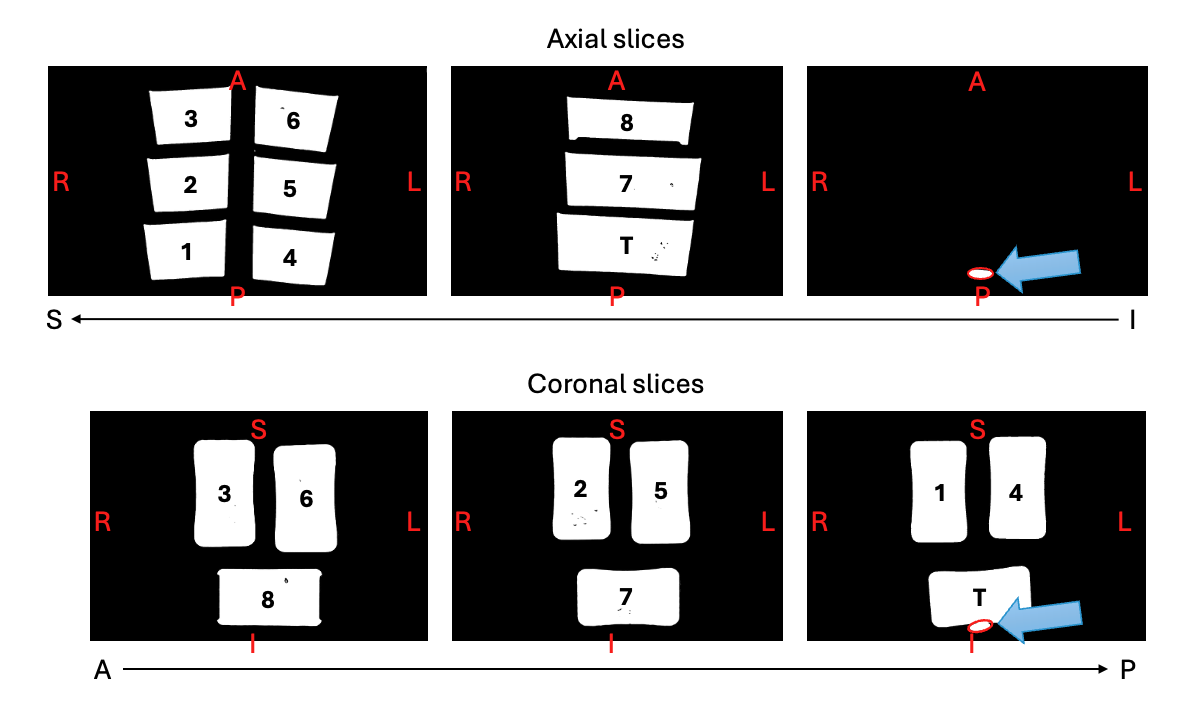

## T1

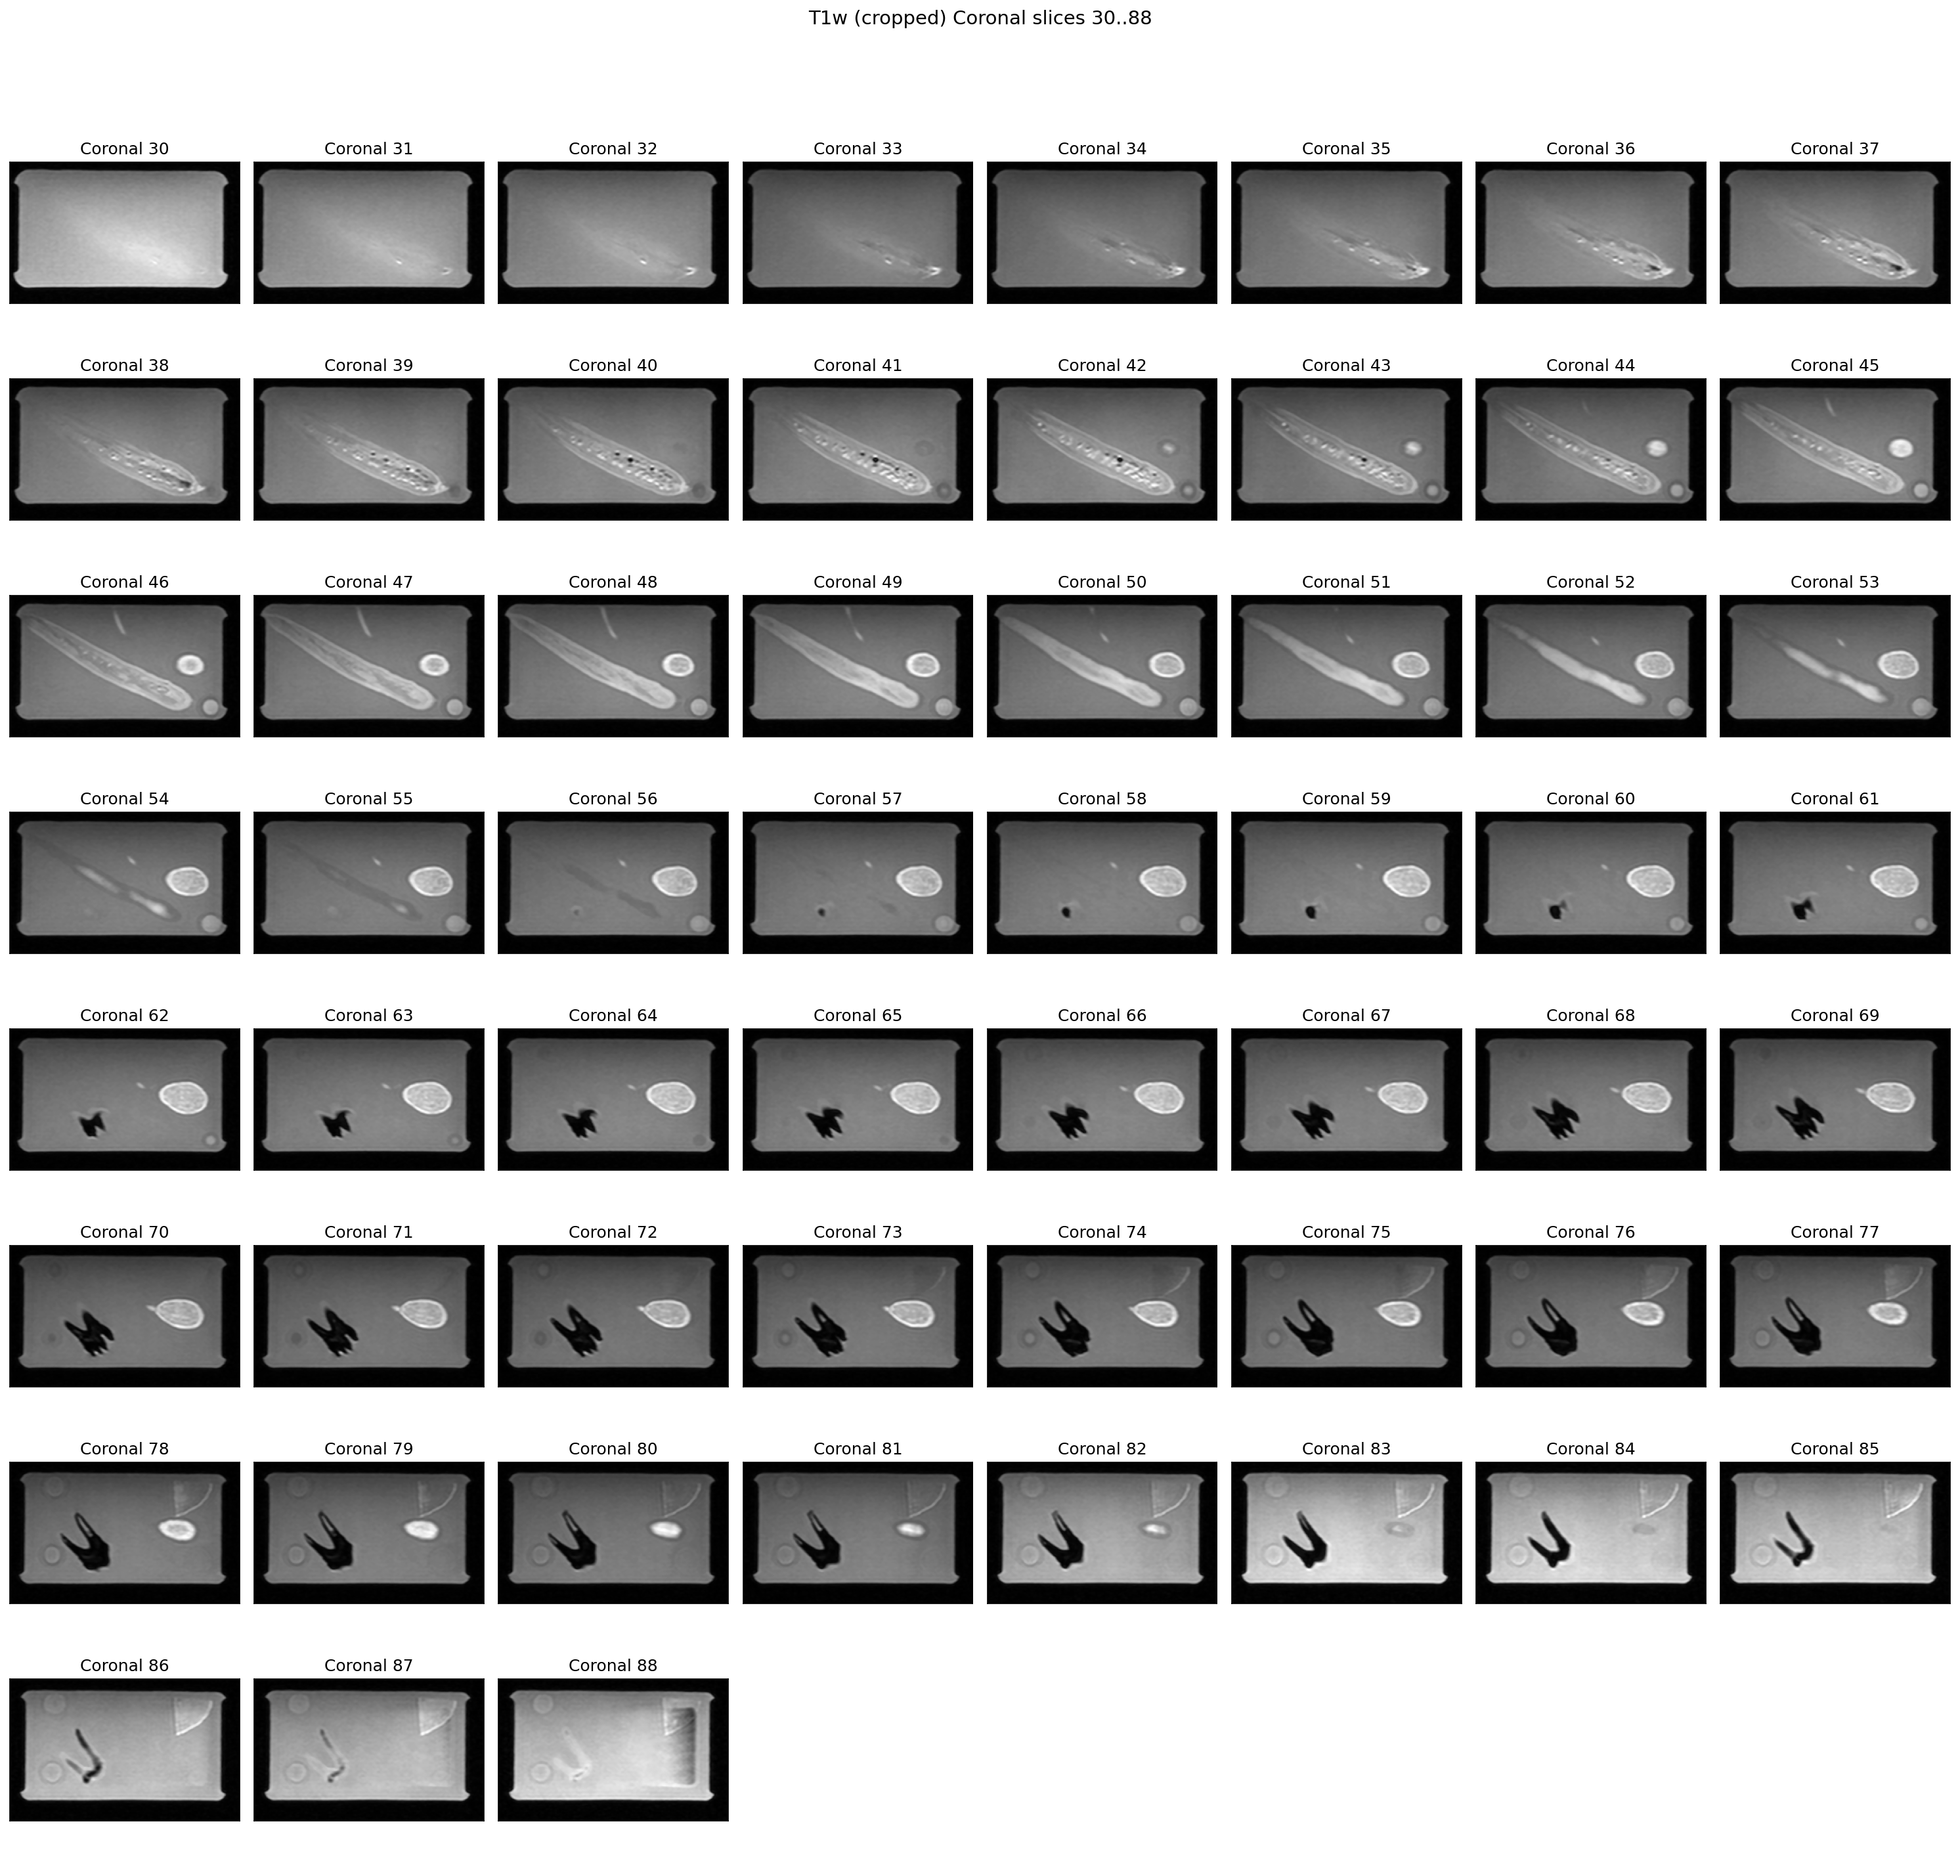

In [8]:
import math
import numpy as np

# Plot coronal slices 30 through 88 from the T1-weighted cropped region
import matplotlib.pyplot as plt

# Desired coronal slice indices (within the cropped volume)
slice_start = 30
slice_end = 88  # inclusive

# Use existing crop limits (defined earlier in the notebook)
# If these variables are not present, adjust them accordingly.
try:
    AP_mm, RL_mm, SI_mm
except NameError:
    AP_mm = (35, 85)
    RL_mm = (20, 150)
    SI_mm = (150, 230)

# Compute voxel crop ranges for T1w
AP_vox = np.rint(np.array(AP_mm) / t1w_voxel[0]).astype(int)
RL_vox = np.rint(np.array(RL_mm) / t1w_voxel[1]).astype(int)
SI_vox = np.rint(np.array(SI_mm) / t1w_voxel[2]).astype(int)

cropped = t1w_img3d[AP_vox[0]:AP_vox[1], RL_vox[0]:RL_vox[1], SI_vox[0]:SI_vox[1]]
AP_dim, RL_dim, SI_dim = cropped.shape
ap_size, rl_size, si_size = t1w_voxel

# Clip requested range to available coronal slices
slice_start = max(0, slice_start)
slice_end = min(AP_dim - 1, slice_end)
if slice_start > slice_end:
    raise ValueError(f"Requested slice range {slice_start}-{slice_end} is outside cropped coronal range 0-{AP_dim-1}.")

n_plots = slice_end - slice_start + 1
cols = min(8, n_plots)
rows = math.ceil(n_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5), dpi=150)
axes = np.atleast_2d(axes)
fig.suptitle(f"T1w (cropped) Coronal slices {slice_start}..{slice_end}", fontsize=14)

for i in range(n_plots):
    row, col = divmod(i, cols)
    ax = axes[row, col]
    sidx = slice_start + i
    img = np.rot90(cropped[sidx, :, :])
    extent = [0, RL_dim * rl_size, SI_dim * si_size, 0]
    ax.imshow(img, cmap='gray', extent=extent)
    ax.set_title(f"Coronal {sidx}")
    ax.set_xticks([])
    ax.set_yticks([])

# Turn off any unused axes
for j in range(n_plots, rows * cols):
    r, c = divmod(j, cols)
    axes[r, c].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
def show_slice(img3d, voxel_size, slice_mm, orientation,
               crop_AP_mm=None, crop_RL_mm=None, crop_SI_mm=None,
               colormap='gray', voxel_units="", title_prefix=""):
    """
    Show ONE MRI slice (axial, sagittal, coronal) with correct aspect
    and mm-accurate cropping.
    """

    # Convert crop mm → voxel index ranges
    def mm_to_idx(mm_range, vox):
        i0 = int(np.floor(mm_range[0] / vox))
        i1 = int(np.ceil(mm_range[1]  / vox))
        return slice(i0, i1)

    crop_AP = mm_to_idx(crop_AP_mm, voxel_size[0]) if crop_AP_mm else slice(None)
    crop_RL = mm_to_idx(crop_RL_mm, voxel_size[1]) if crop_RL_mm else slice(None)
    crop_SI = mm_to_idx(crop_SI_mm, voxel_size[2]) if crop_SI_mm else slice(None)

    # Convert slice location mm → voxel index
    axis_map = {"coronal":0, "sagittal":1, "axial":2}
    slice_idx = int(round(slice_mm / voxel_size[axis_map[orientation]]))

    # ==========================
    # Extract the slice
    # ==========================
    if orientation == "axial":
        img = img3d[crop_AP, crop_RL, slice_idx]
        extent = [
            crop_RL.start * voxel_size[1], crop_RL.stop * voxel_size[1],
            crop_AP.stop * voxel_size[0], crop_AP.start * voxel_size[0]
        ]
        xlabel, ylabel = "R-L [mm]", "A-P [mm]"

    elif orientation == "sagittal":
        img = img3d[crop_AP, slice_idx, crop_SI]
        img = np.rot90(img, 1)
        extent = [
            crop_AP.start * voxel_size[0], crop_AP.stop * voxel_size[0],
            crop_SI.start * voxel_size[2], crop_SI.stop * voxel_size[2]
        ]
        xlabel, ylabel = "A-P [mm]", "S-I [mm]"

    elif orientation == "coronal":
        img = img3d[slice_idx, crop_RL, crop_SI]
        img = np.rot90(img, 1)
        extent = [
            crop_RL.start * voxel_size[1], crop_RL.stop * voxel_size[1],
            crop_SI.start * voxel_size[2], crop_SI.stop * voxel_size[2]
        ]
        xlabel, ylabel = "R-L [mm]", "S-I [mm]"

    # ==========================
    # Plot with correct aspect
    # ==========================
    plt.figure(figsize=(7, 7))
    im = plt.imshow(img, cmap=colormap, extent=extent, aspect='equal')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.title(f"{title_prefix} {orientation.capitalize()} slice "
              f"(mm={slice_mm:.1f}, voxel={slice_idx})")

    plt.colorbar(im, fraction=0.046, pad=0.04, label=voxel_units)
    plt.tight_layout()
    plt.show()


## Object 1

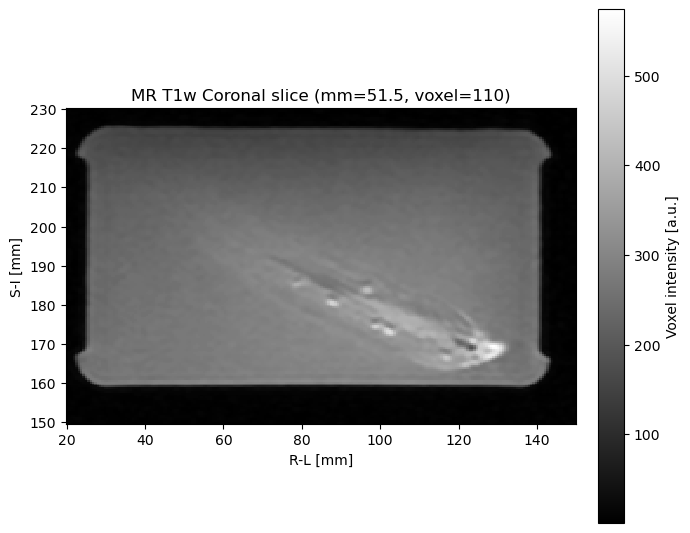

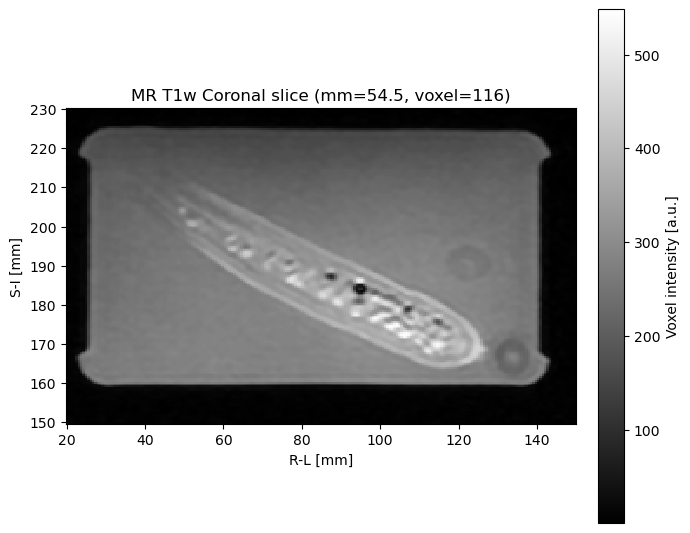

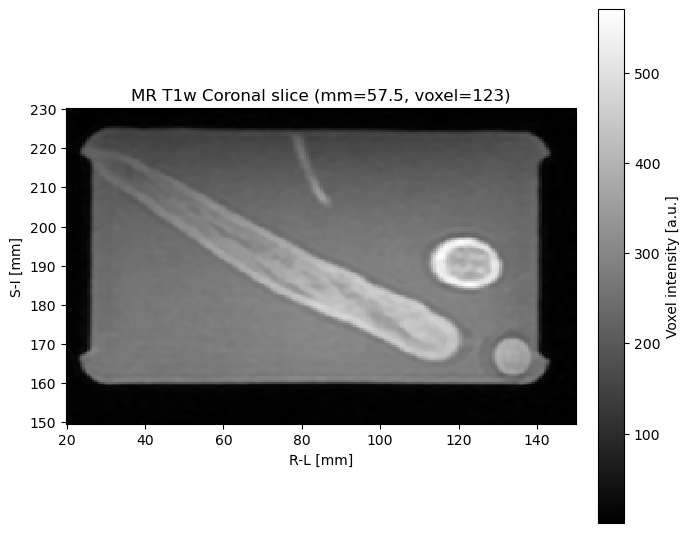

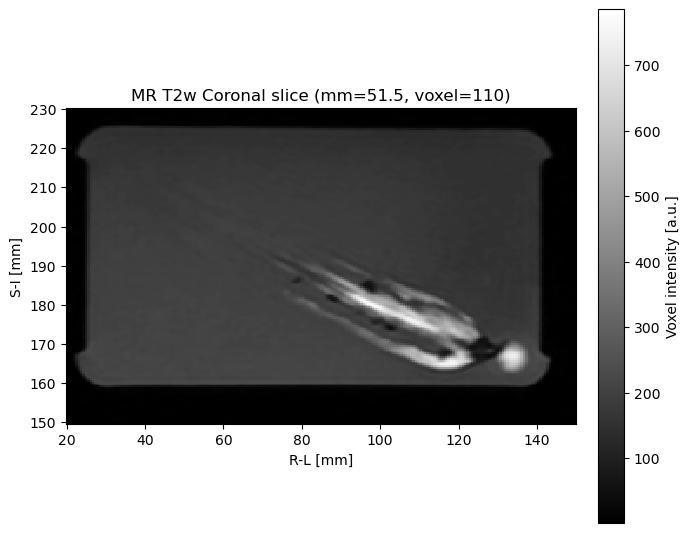

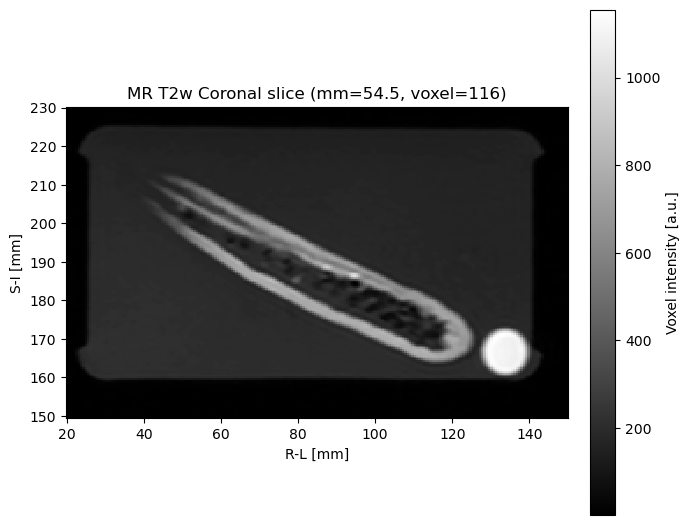

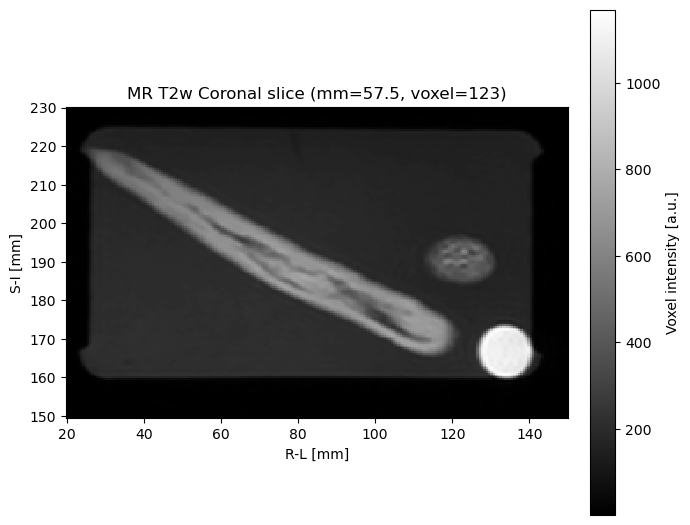

In [122]:
AP_mm  = (35, 85)
RL_mm  = (20, 150)
SI_mm  = (150, 230)

Object1SliceSearch = 51.5

show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=Object1SliceSearch,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]"
)

show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=Object1SliceSearch+3,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]"
)
show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=Object1SliceSearch+6,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]"
)

# ==========================
# Repeat for T2
# ==========================

show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=Object1SliceSearch,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]"
)

show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=Object1SliceSearch+3,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]"
)
show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=Object1SliceSearch+6,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]"
)

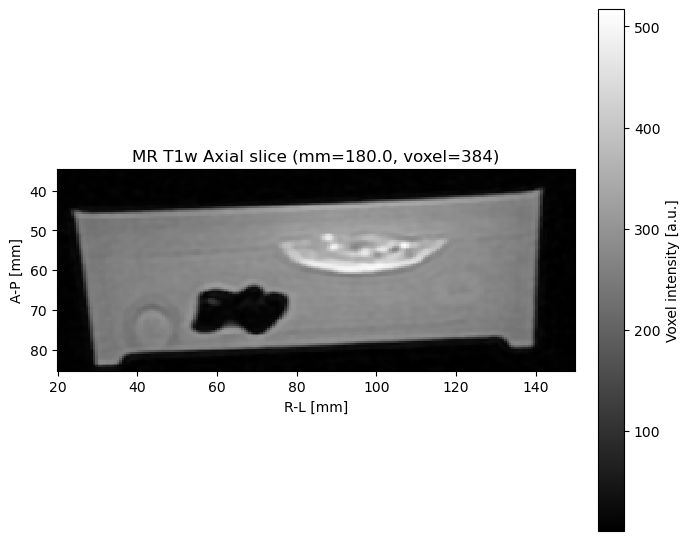

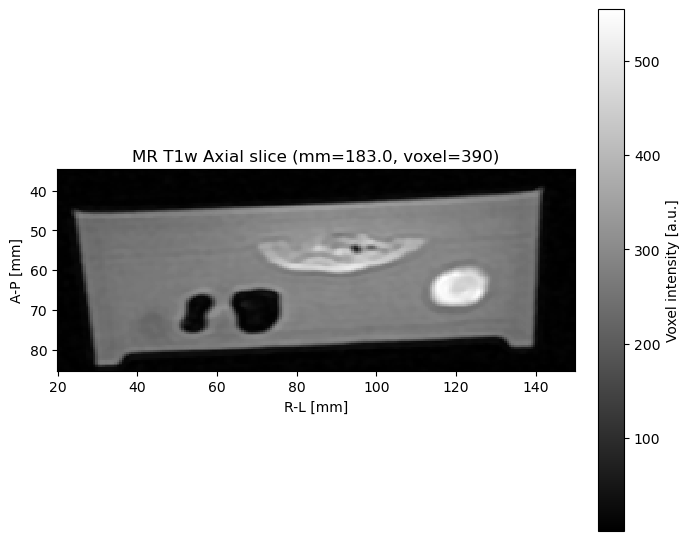

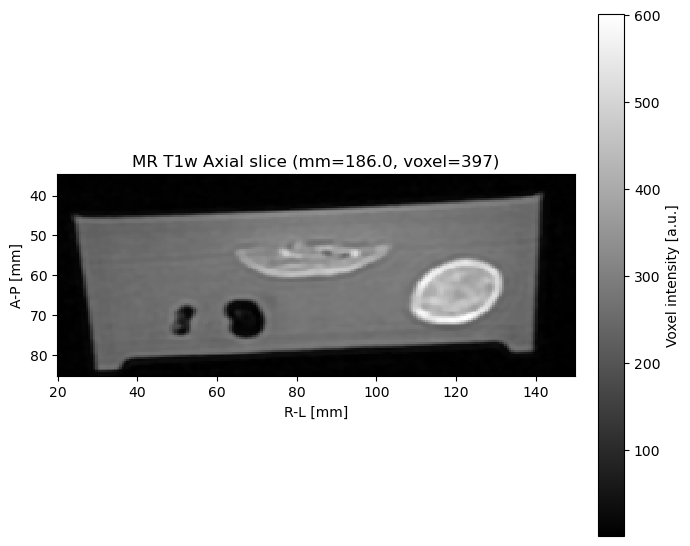

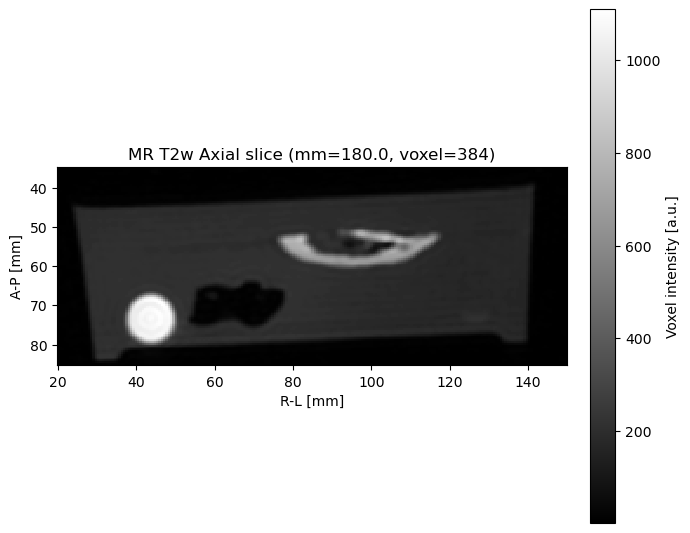

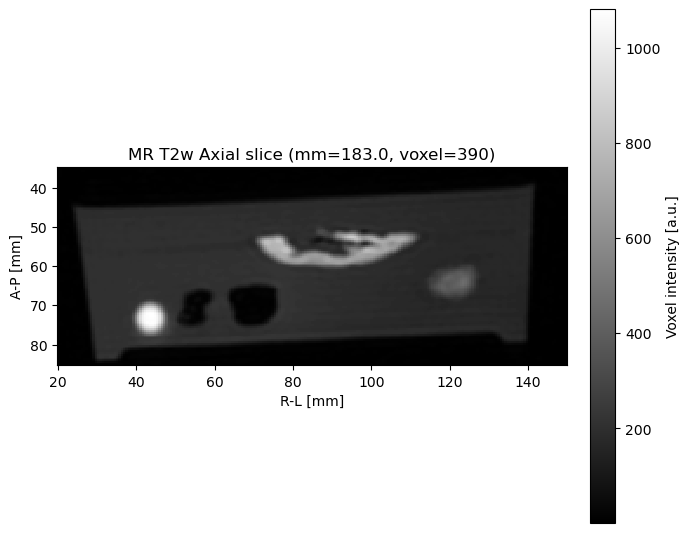

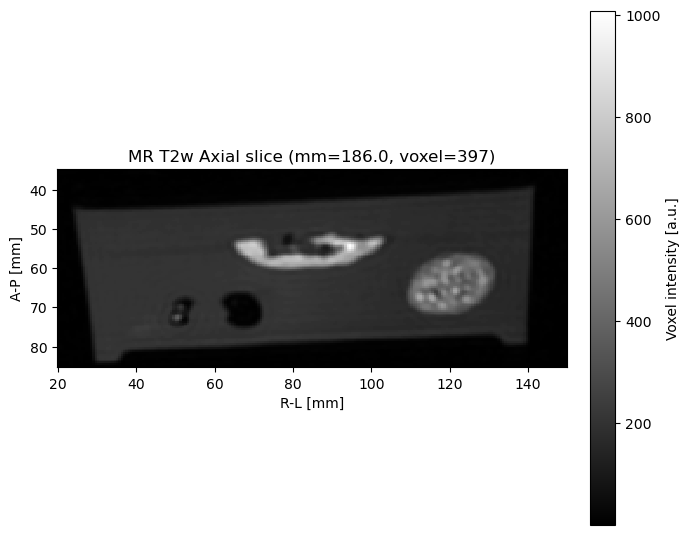

In [124]:
Object1SliceSearch = 180

show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=Object1SliceSearch,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]"
)

show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=Object1SliceSearch+3,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]"
)
show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=Object1SliceSearch+6,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]"
)

# ==========================
# Repeat for T2
# ==========================

show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=Object1SliceSearch,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]"
)

show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=Object1SliceSearch+3,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]"
)
show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=Object1SliceSearch+6,
    orientation="axial",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]"
)

## Object 2

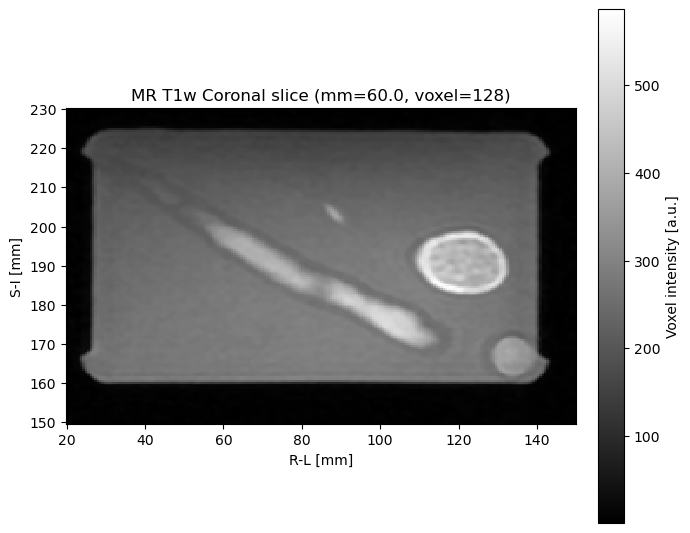

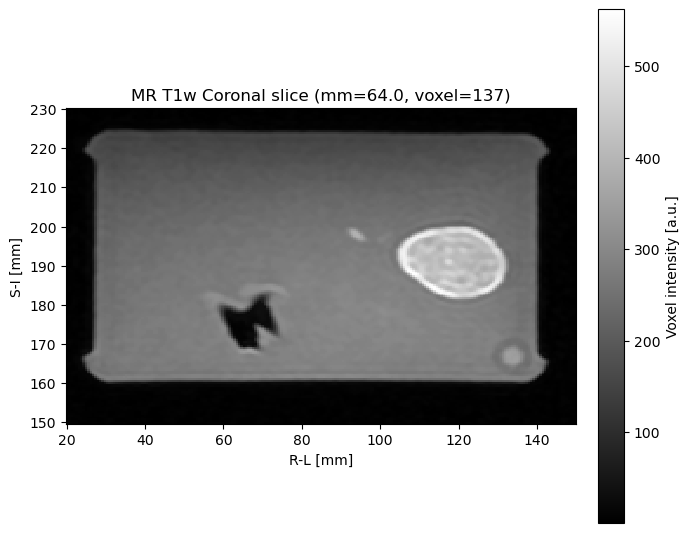

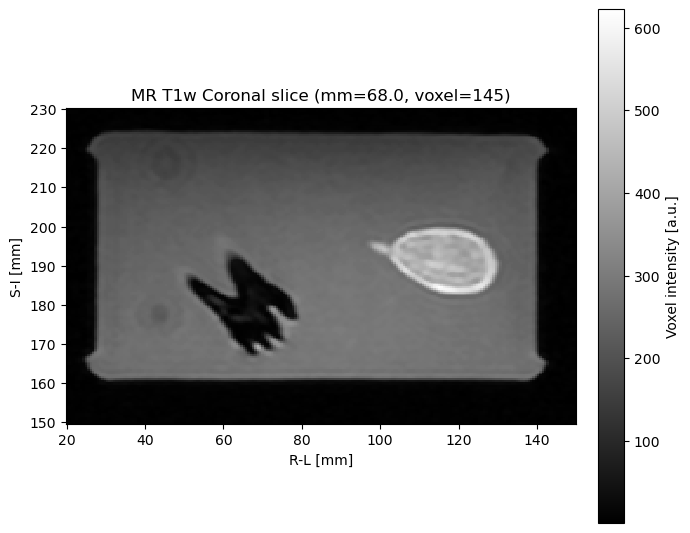

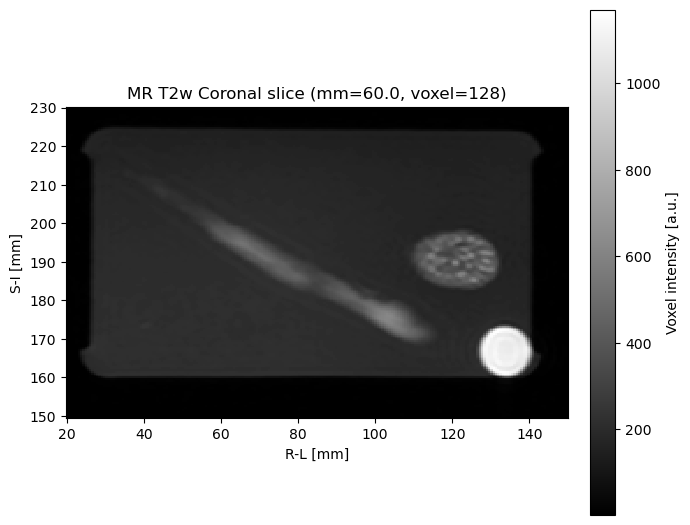

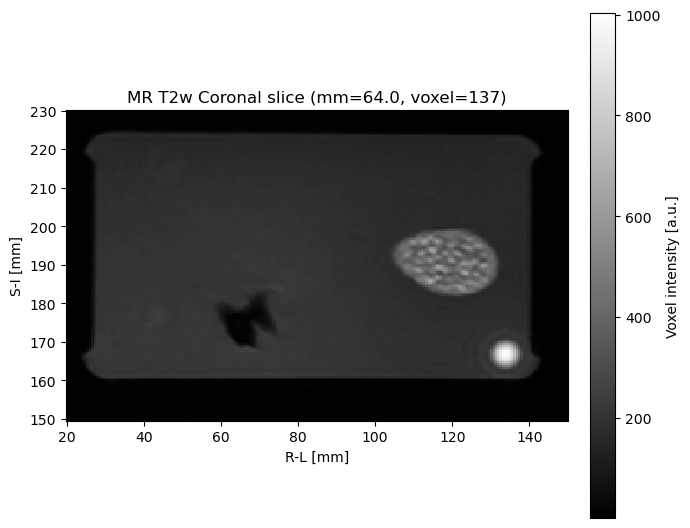

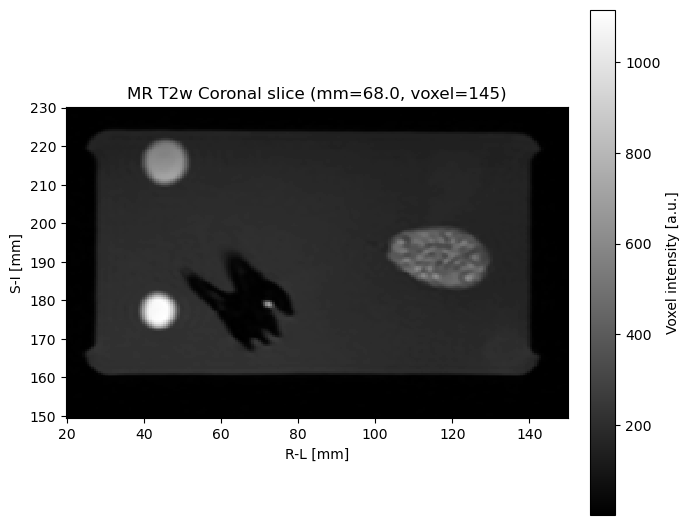

In [120]:
Object2SliceSearch = 60

show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=Object2SliceSearch,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]"
)

show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=Object2SliceSearch+4,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]"
)

show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=Object2SliceSearch+8,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]"
)

# ==========================
# Repeat for T2
# ==========================

show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=Object2SliceSearch,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]"
)

show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=Object2SliceSearch+4,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]"
)

show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=Object2SliceSearch+8,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]"
)

## Object 3

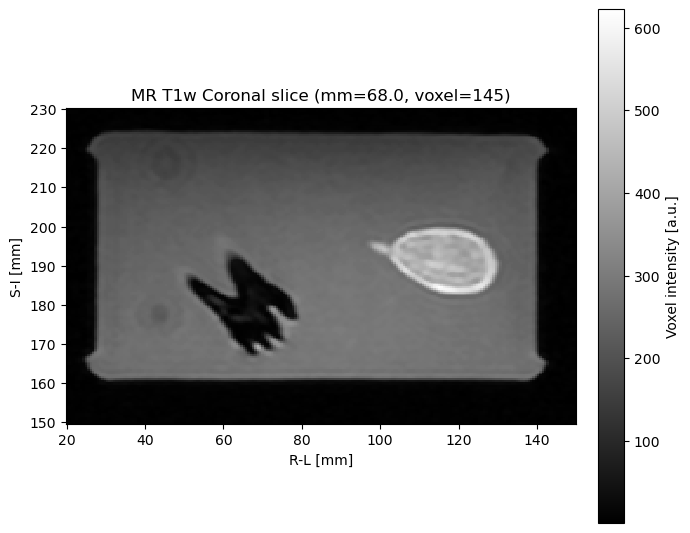

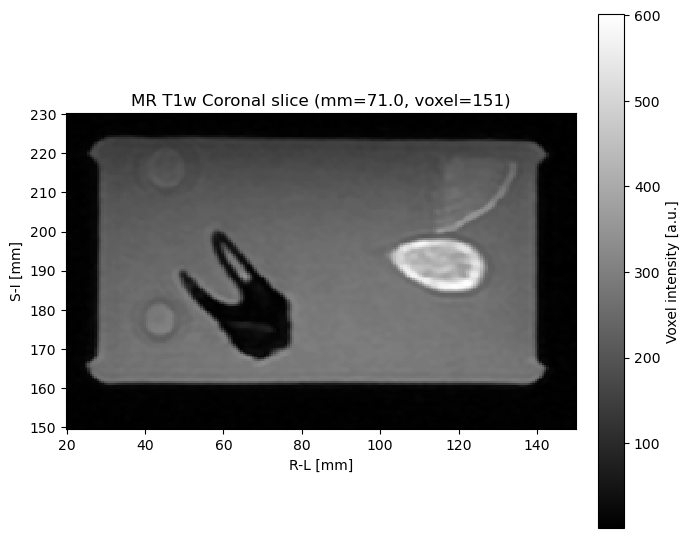

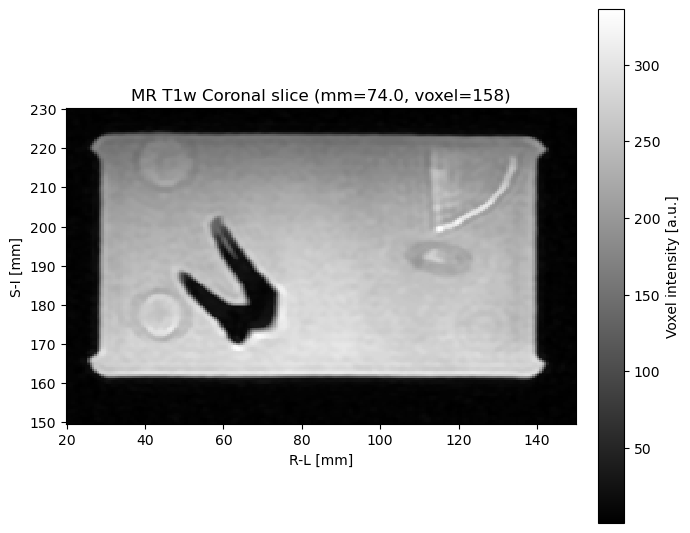

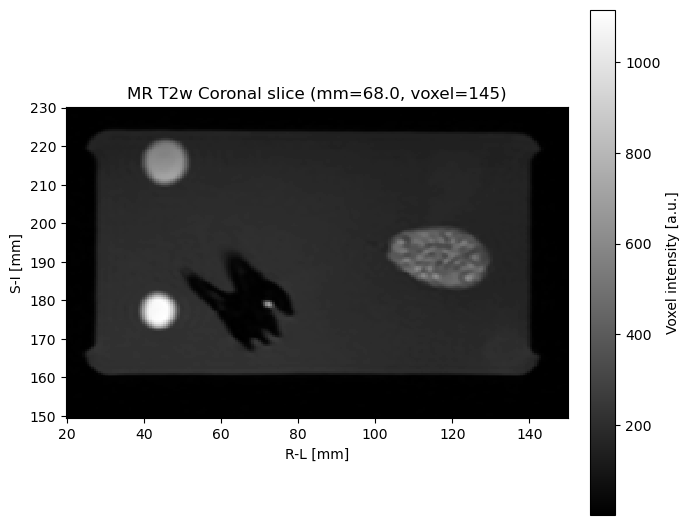

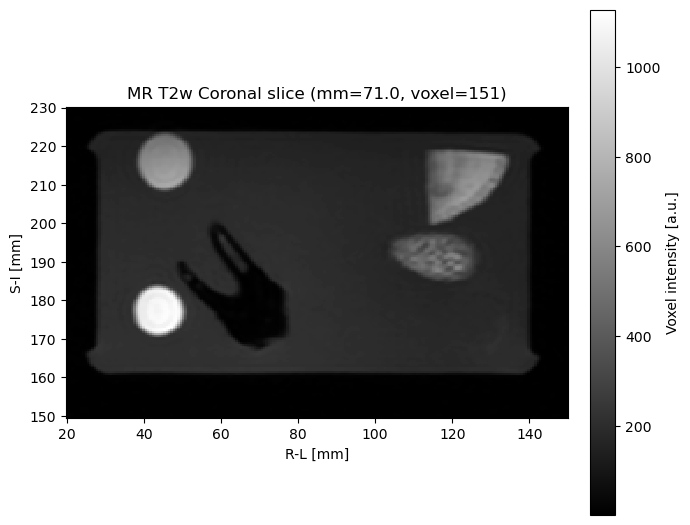

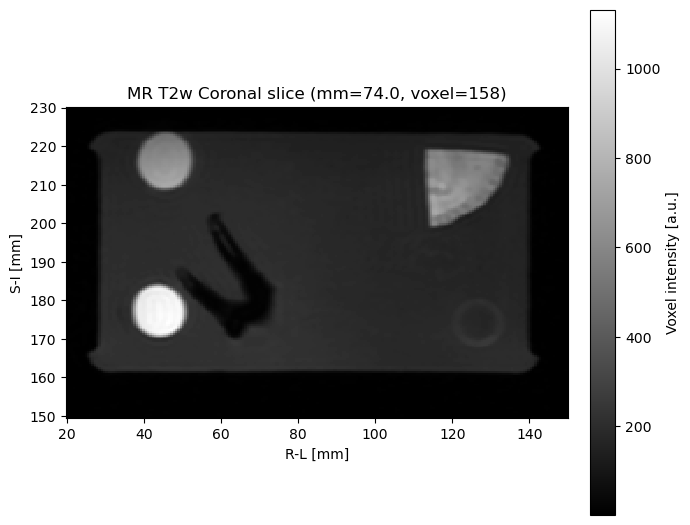

In [119]:
Object3SliceSearch = 68

show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=Object3SliceSearch,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]"
)
show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=Object3SliceSearch+3,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]"
)
show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=Object3SliceSearch+6,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]"
)

# ==========================
# Repeat for T2
# ==========================

show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=Object3SliceSearch,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]"
)
show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=Object3SliceSearch+3,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]"
)
show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=Object3SliceSearch+6,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]"
)

## Object 4

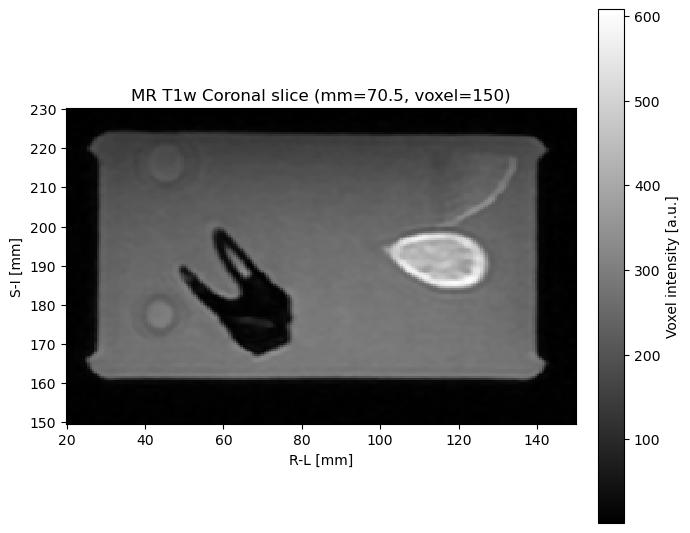

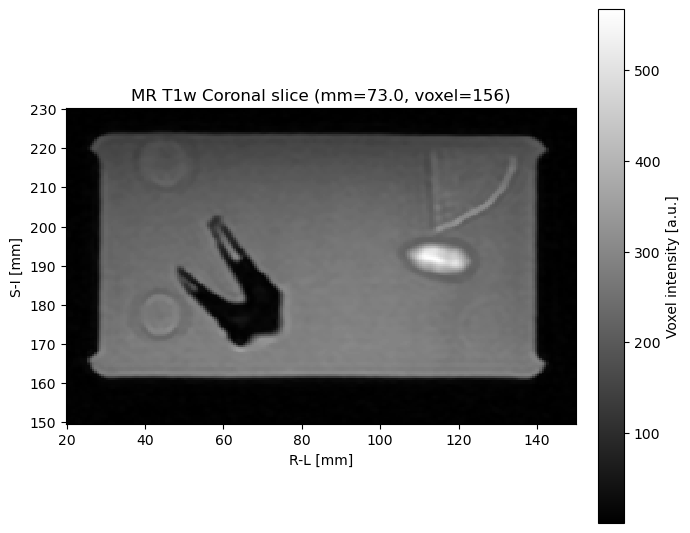

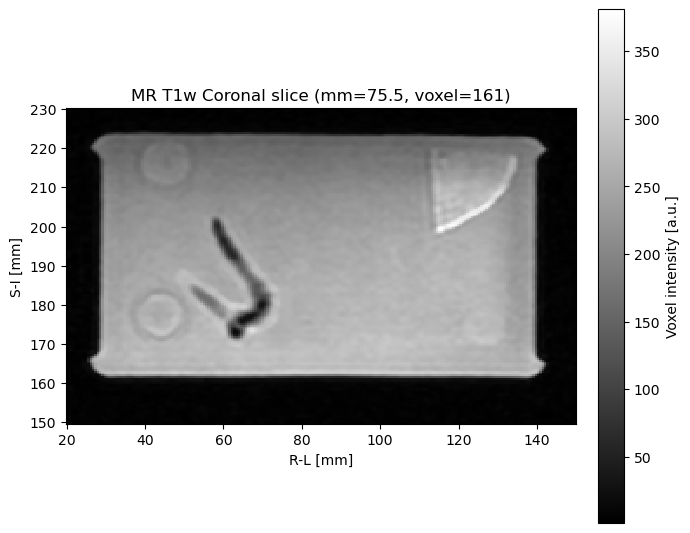

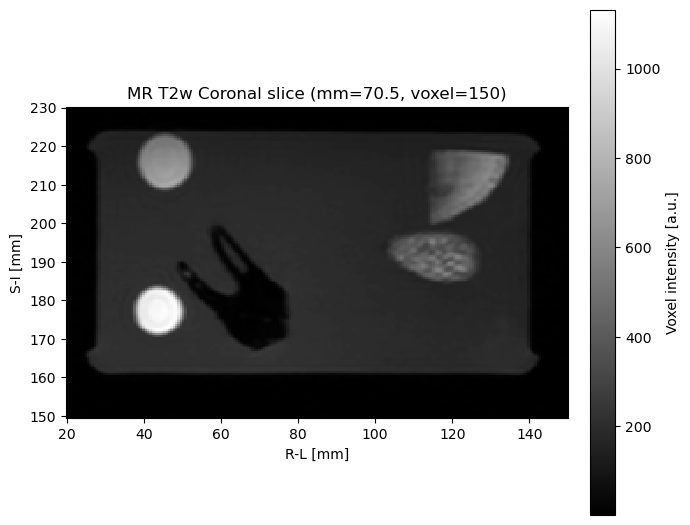

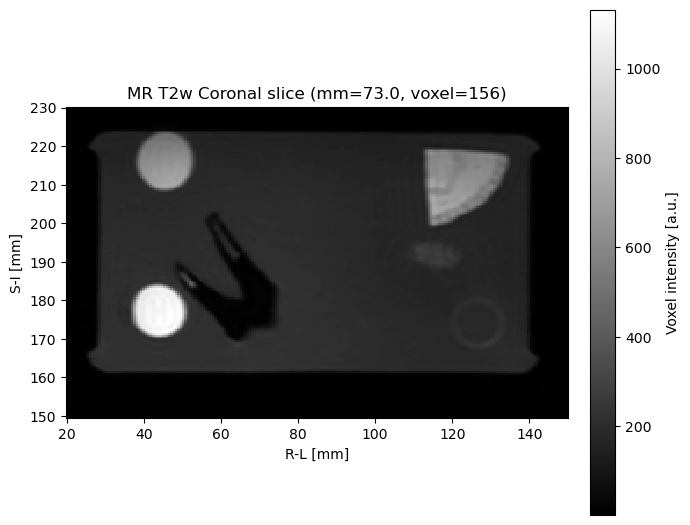

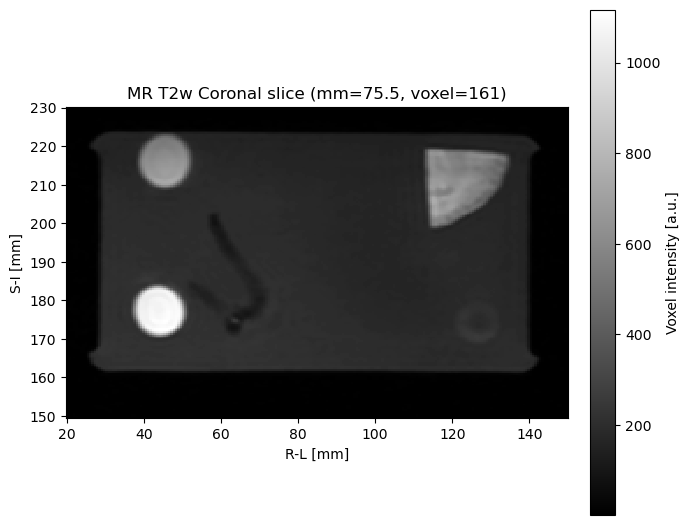

In [118]:
Object4SliceSearch = 70.5

show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=Object4SliceSearch,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]"
)
show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=Object4SliceSearch+2.5,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]"
)
show_slice(
    t1w_img3d, t1w_voxel,
    slice_mm=Object4SliceSearch+5,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T1w",
    voxel_units="Voxel intensity [a.u.]"
)

show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=Object4SliceSearch,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]"
)
show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=Object4SliceSearch+2.5,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]"
)
show_slice(
    t2w_img3d, t2w_voxel,
    slice_mm=Object4SliceSearch+5,
    orientation="coronal",
    crop_AP_mm=AP_mm,
    crop_RL_mm=RL_mm,
    crop_SI_mm=SI_mm,
    title_prefix="MR T2w",
    voxel_units="Voxel intensity [a.u.]"
)